In [1]:
import pandas as pd
import numpy as np
import csv
import re
import json
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from scipy.sparse import lil_matrix
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def replace_commas_in_arrays(line):
    return re.sub(r'\[([^\]]+)\]', lambda x: '[' + x.group(1).replace(',', ';') + ']', line)

input_file = '/content/drive/MyDrive/data.csv'
output_file = '/content/data_modifie.csv'

with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    for row in reader:
        row_str = ','.join(row)
        modified_row_str = replace_commas_in_arrays(row_str)
        modified_row = modified_row_str.split(',')
        writer.writerow(modified_row)

print("Fichier modifie avec succes ")

Fichier modifie avec succes 


In [4]:
df=pd.read_csv("/content/data_modifie.csv")

In [5]:
df.head()

,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,1969527638,LlngoMakeEmCum_,"[ ""#nationaldogday"" ]",http://pbs.twimg.com/profile_images/5342862178...,319,112,en,1472271687519,769310701580083200,"[ ""1969574754""; ""1969295556""; ""1969284056""; ""1..."
1,51878493,_notmichelle,"[ ""#nationaldogday"" ]",http://pbs.twimg.com/profile_images/7619776021...,275,115,en,1472270622663,769309490038439936,"[ ""60789485""; ""2420931980""; ""2899776756""; ""127..."
2,1393409100,jesseayye,"[ ""#narcos"" ]",http://pbs.twimg.com/profile_images/7132829382...,120,107,en,1472804144409,771622623583186944,"[ ""86868062""; ""19697415""; ""2998836604""; ""45629..."
3,232891415,MrBrianLloyd,"[ ""#gloryoutnow"" ]",http://pbs.twimg.com/profile_images/1334406683...,492,325,en,1472269186776,769308131696467969,"[ ""361335082""; ""1405248468""; ""24626354""; ""7256..."
4,710130422907207680,sarahdorat_16,"[ ""#nationaldogday"" ]",http://pbs.twimg.com/profile_images/7671805202...,128,218,en,1472271397356,769309769144283137,"[ ""1571896093""; ""768938323612008448""; ""2548665..."


In [6]:
df['tweetId'].nunique()

40000

In [7]:
df=df.drop(['screenName','tags','avatar','lang','tweetId','lastSeen'],axis=1)

In [8]:
df['id'].nunique()

40000

In [9]:
df.head()

,id,followersCount,friendsCount,friends
0,1969527638,319,112,"[ ""1969574754""; ""1969295556""; ""1969284056""; ""1..."
1,51878493,275,115,"[ ""60789485""; ""2420931980""; ""2899776756""; ""127..."
2,1393409100,120,107,"[ ""86868062""; ""19697415""; ""2998836604""; ""45629..."
3,232891415,492,325,"[ ""361335082""; ""1405248468""; ""24626354""; ""7256..."
4,710130422907207680,128,218,"[ ""1571896093""; ""768938323612008448""; ""2548665..."


In [10]:
#
df=df.head(100)

In [11]:
def convert_to_list(friends_str):
    corrected_str = friends_str.replace(';', ',')
    return json.loads(corrected_str)

In [12]:
df['friends'] = df['friends'].apply(convert_to_list)

In [13]:
unique_ids = set()
for friends in df['friends']:
    unique_ids.update(int(friend) for friend in friends)

In [14]:
len(unique_ids)

19657

In [15]:
df.shape

(100, 4)

In [16]:
"""
sparse_matrix = lil_matrix((len(df.index), len(unique_ids)), dtype=np.int8)

friends_matrix = pd.DataFrame.sparse.from_spmatrix(
    sparse_matrix,
    index=df.index,
    columns=list(unique_ids)
)
"""

'\nsparse_matrix = lil_matrix((len(df.index), len(unique_ids)), dtype=np.int8)\n\nfriends_matrix = pd.DataFrame.sparse.from_spmatrix(\n    sparse_matrix,\n    index=df.index,\n    columns=list(unique_ids)\n)\n'

In [17]:
friends_matrix = pd.DataFrame(0, index=df.index, columns=list(unique_ids))

In [18]:
friends_matrix = pd.DataFrame(0, index=df.index, columns=list(unique_ids))
friends_matrix.columns = friends_matrix.columns.astype(int)
for index, row in df.iterrows():
    for friend_id in row['friends']:
        friend_id = int(friend_id)
        if friend_id in friends_matrix.columns:
            friends_matrix.at[index, friend_id] = 1


df_final = pd.concat([df.drop(columns=['friends']), friends_matrix], axis=1)

In [19]:
friends_matrix.shape

(100, 19657)

In [20]:
df_final.fillna(0, inplace=True)

In [21]:
#df_final['total_friends'] = df_final.iloc[:, 3:].sum(axis=1)

In [22]:
df_final

,id,followersCount,friendsCount,768938323612008448,736409486949122048,745695548246720513,715886426387120129,713030233054511105,707387411316080642,746928595075891200,...,2422636526,430342127,820051950,2344386542,129400817,153845743,20250612,145129460,3390046198,394297339
0,1969527638,319,112,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,51878493,275,115,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1393409100,120,107,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,232891415,492,325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,710130422907207680,128,218,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,729086055274582016,440,110,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,166677653,1874,686,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,1187590927,938,844,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,2889779582,568,326,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_final.to_csv('TEST.csv', index=False)

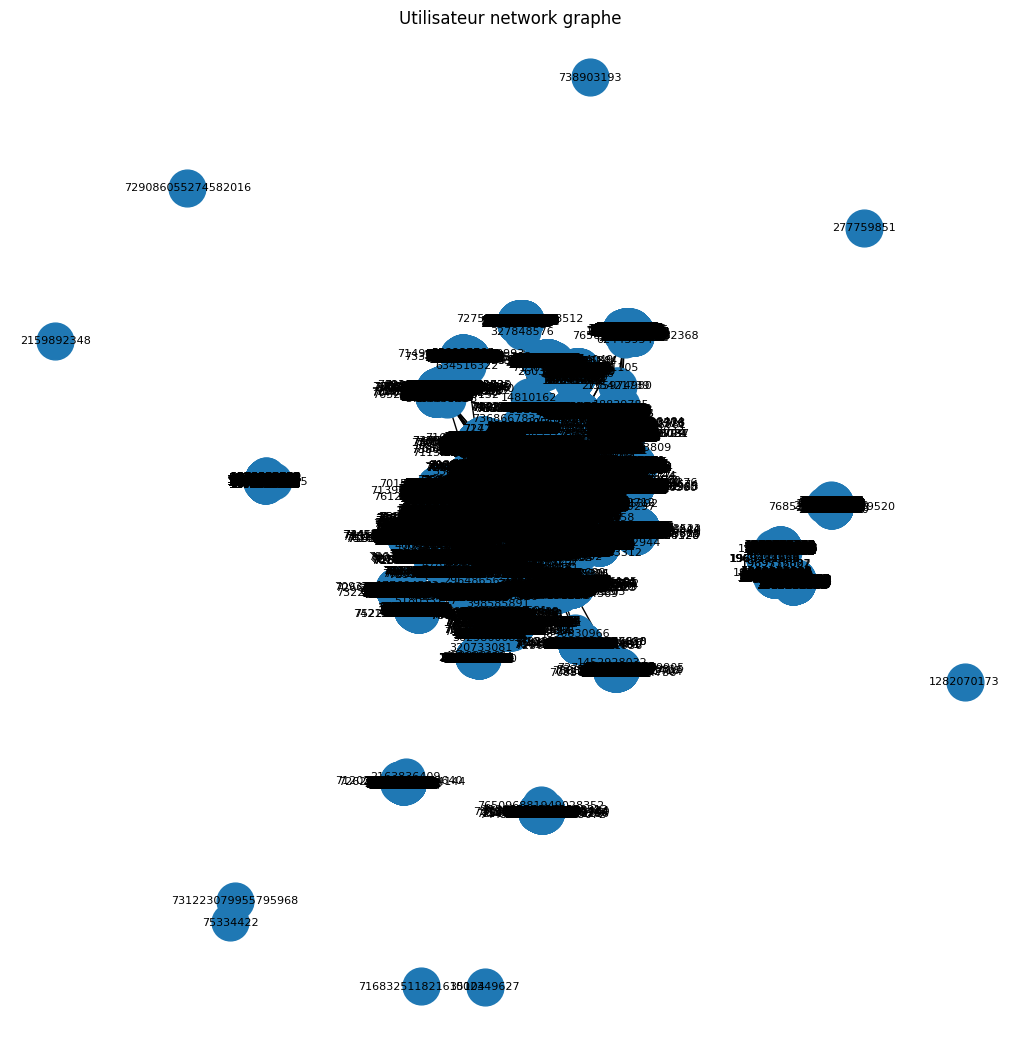

In [24]:

G = nx.Graph()

for user_id in df_final['id']:
    G.add_node(user_id)

for index, row in df.iterrows():
    user_id = row['id']
    friends = row['friends']
    for friend_id in friends:
        G.add_edge(user_id, friend_id)

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=700, font_size=8)
plt.title("Utilisateur network graphe")
plt.show()
